In [2]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2


In [10]:
os.chdir('/home/jenhan/analysis/scratch/')

In [11]:
!ls

atac
C57Bl6-NCoR-KO_BMDM_NCoR_Veh_Josh_15-02-17_peaks_C57Bl6-NCoR-KO_BMDM_NCoR_Veh_JSS_14-11-04_peaks_idr.tsv
CCMKO_all_rpkm.txt
cmmko_idr
Coccidioidomycosis-AnalyzeRepeats-Log4NeutrophilGenes_Cocci.txt
merged.tsv
ncor_veh_peaks.tsv


In [14]:
frame = pd.read_csv('Coccidioidomycosis-AnalyzeRepeats-Log4NeutrophilGenes_Cocci.txt',sep='\t')

In [15]:
frame

,Transcript/RepeatID (cmd=analyzeRepeats.pl rna mm10 -log -pc 3 -condenseGenes -count exons -d data/mm10/Lung/RNA/Lung-PolyA-Balbc-ControlA-14-03-20/ data/mm10/Lung/RNA/Lung-PolyA-Balbc-ControlB-14-03-20/ data/mm10/Lung/RNA/Lung-PolyA-Balbc-Coccidioidomycosis12-14-03-20/ data/mm10/Lung/RNA/Lung-PolyA-Balbc-Coccidioidomycosis13-14-03-20/ data/mm10/Lung/RNA/Lung-PolyA-Balbc-IL8rKO-ControlC-14-03-20/ data/mm10/Lung/RNA/Lung-PolyA-Balbc-IL8rKO-ControlD-14-03-20/ data/mm10/Lung/RNA/Lung-PolyA-Balbc-IL8rKO-Coccidioidomycosis1-14-03-20/ data/mm10/Lung/RNA/Lung-PolyA-Balbc-IL8rKO-Coccidioidomycosis5-14-03-20/),chr,start,end,strand,Length,Copies,Annotation/Divergence,Annotation/Divergence.1,WT-Cocci,KO-Cocci
0,NM_001166375,chr8,66386301,66471637,+,3936,1,Mrgpra2b,Mrgpra2b|MrgA2|Mrgpra2|OTTMUSG00000028717|-|7 ...,6.4720,3.1495
1,NM_023116,chr2,14604306,14987908,+,3929,1,Csf3r,Csf3r|Cd114|Csfgr|G-CSF-R|G-CSFR|RP23-140F18.1...,10.9265,8.4170
2,NM_134072,chr13,4059591,4090422,+,2434,1,Slfn4,Slfn4|AI450778|RP23-308N3.2|11 C|11|protein-co...,11.8750,9.3635
3,NM_018773,chr6,51859165,52012549,-,1624,1,Il1f9,Il1f9|Il36g|RP23-176J12.3|2 A3|2 16.24 cM|prot...,10.6235,5.2360
4,NM_021334,chr7,128129568,128150657,+,3993,1,Mgam,Mgam|6030407P20Rik|MGA|-|6 B1|6|protein-coding,6.2520,3.7080
5,NM_019566,chr7,102239123,102250118,-,1260,1,Mrgpra2a,Mrgpra2a|-|-|7 B4|7|protein-coding,4.2510,1.8625
6,NM_001081205,chr5,72647796,72671078,+,4197,1,Ankrd22,Ankrd22|5430429D21Rik|D19Ertd675e|-|19 C1|19 2...,6.2555,3.1735
7,NM_153573,chr6,54577605,54593128,-,2638,1,Sfxn5,Sfxn5|C230001H08Rik|-|6 D1|6 37.23 cM|protein-...,7.9030,7.2410
8,NM_001177720,chr2,91137360,91179321,-,5868,1,Ppp1r3d,Ppp1r3d|2610024M03Rik|Gm359|RP23-160K5.3|2 H4|...,7.8840,6.4570
9,NM_016719,chr2,64912482,65022766,-,1948,1,Arg2,Arg2|AII|AU022422|-|12 C3|12|protein-coding,10.1855,8.5510


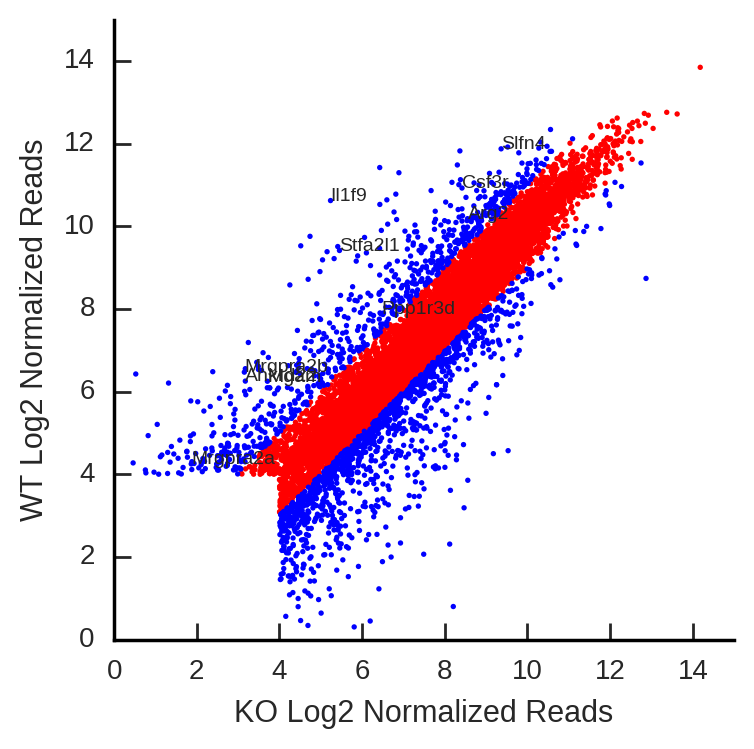

In [37]:
sns.set_style('ticks',{'axes.edgecolor': 'black',
                       'xtick.direction': 'in',
                       'ytick.direction': 'in', 
                         })


target_genes = frame['Annotation/Divergence'].values[:11]
target_genes = [x.upper() for x in target_genes]

  
fdr_threshold = 0.05
fold_threshold = 2
rpkm_cutoff = 4.0


reads1 = frame['KO-Cocci'].values
reads2 = frame['WT-Cocci'].values

all_genes = frame['Annotation/Divergence'].values
read_tuple_list = tuple(zip(all_genes, reads1, reads2))
filtered_read_tuple_list = [x for x in read_tuple_list if x[1] >= rpkm_cutoff or x[2]>= rpkm_cutoff ]

filtered_genes = [x[0] for x in filtered_read_tuple_list]
reads1 = np.array([2**x[1] for x in filtered_read_tuple_list])
reads2 = np.array([2**x[2] for x in filtered_read_tuple_list])
 # log values
logged_reads1 = np.log2(reads1 + 0.01)
logged_reads2 = np.log2(reads2 + 0.01)

label_x = []
label_y = []
fold_genes = []
for i in range(len(filtered_genes)): 
    fold = (reads1[i]+0.000001)/(reads2[i]+0.0000001)
    if fold >=fold_threshold or fold <=1/fold_threshold:
        fold_genes.append(filtered_genes[i])
        label_x.append(logged_reads1[i])
        label_y.append(logged_reads2[i])

#             colors = ['blue' if x in diff_genes and x in fold_genes else 'grey' if x in fold_genes else 'lightgrey' for x in idr_rpkm_frame.index.values]
#             colors = ['blue' if x in diff_genes or x in fold_genes else 'red' for x in filtered_genes]
colors = ['blue' if x in fold_genes else 'red' for x in filtered_genes]


# ensure diff diff expressed genes are on top
val_tuples = tuple(zip(logged_reads1,logged_reads2,colors))
sorted_tuples = sorted(val_tuples,key=lambda x: x[2], reverse=True)
logged_reads1 = [x[0] for x in sorted_tuples] 
logged_reads2 = [x[1] for x in sorted_tuples]
colors = [x[2] for x in sorted_tuples]
plt.figure(figsize=(4,4))
plt.scatter(logged_reads1, logged_reads2, edgecolors='none', c=colors, marker = '.', s=15)
### annotate differentially expressed genes
offset = -1
for label, x, y in zip(fold_genes, label_x, label_y):
    if label.upper() in target_genes:
        if x < y:
            plt.annotate(
                label, 
                xy = (x, y),
                size=7)

        else:
            plt.annotate(
                label, 
                xy = (x, y),
                size=7)
    if offset == 1:
        offset=-1
    else: 
        offset = 1
sns.despine()
# fix aspect ratio
ax = plt.gca()
ax.set_xlim((0,15))
ax.set_ylim((0,15))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))        
plt.xlabel('KO Log2 Normalized Reads')
plt.ylabel('WT Log2 Normalized Reads')
#             plt.savefig('./scatter_plots/'+ treatment1 + '_' + treatment2 + '_logRPKM_scatter.png', bbox_inches='tight')
#             plt.savefig('./scatter_plots/'+ treatment1 + '_' + treatment2 + '_logRPKM_scatter.pdf', bbox_inches='tight')
#             plt.show()
plt.savefig('scatter_plot.pdf')